# Simple Physics Environment

## Data Collection

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces

In [23]:
class SimplePhyEnv(gym.Env):
    def __init__(self, x0, timestep=1, mass=1):
        super(SimplePhyEnv,self).__init__()
        
        assert(x0.shape == (4,1))
        self.x0 = x0
        self.ts = timestep
        self.m = mass
        
        self.action_space = spaces.Box(low=-1, high=1,
                                       shape=(2,1))
        self.observation_space = spaces.Box(low=-np.Inf, high=np.Inf,
                                            shape=(4,1))
        
        # Initial state
        self.reset()
        # State-space representation
        self.A = np.matrix([[0,0,1,0],
                            [0,0,0,1],
                            [0,0,0,0],
                            [0,0,0,0]])
        self.B = np.matrix([[0,0],
                            [0,0],
                            [1/mass,0],
                            [0,1/mass],])
        
    def reset(self):
        self.x = x0
        return self.x
    
    def step(self, action):
        x_dot = self.A*self.x + self.B*np.matrix(action).reshape((2,1))
        self.x = self.x + x_dot*self.ts
        return self.x

In [51]:
x0 = np.matrix([0,0,0,0]).T
env = SimplePhyEnv(x0)

In [130]:
env.reset()
N = int(1e3)
for i in range(N):
    env.step(env.action_space.sample())
env.x

matrix([[-9115.22270842],
        [ 3523.16122621],
        [   -9.63504317],
        [    9.68211252]])

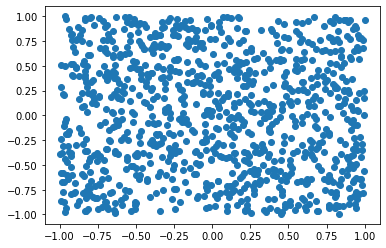

In [119]:
N = int(1e3)
x = np.zeros((N,2))
for i in range(N):
    x[i,:] = env.action_space.sample().reshape((-1,))
plt.scatter(x[:,0],x[:,1]);